<img src="features.png">

In [1]:
import base64
import csv
from collections import OrderedDict
def pre_process(json_data):
    
    reader = csv.DictReader(open('template_model.csv'))
    for line in reader:
        #dic = line
        dic = OrderedDict(sorted(line.items(), key=lambda item: reader.fieldnames.index(item[0])))
        break

    for k in json_data.keys():
        dic[k] = json_data[k]


    aq = pd.DataFrame.from_dict(dic, orient='index')

    return aq.transpose()

In [2]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm=cm.round(4)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="orange" if cm[i, j] > thresh else "blue")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

#---------------------------


In [3]:
def model2(mode,lr,training_epochs,chunk,model_version,DropoutKepProb,number_nodes_layer1):
    import tensorflow as tf
    
    import os
    
    directory="models"
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    file_name="models/model_v"+ model_version +".ckpt"
    if mode=="training":
        
        #tf.reset_default_graph

        #-------------------------------------------
        x = tf.placeholder(tf.float32, [None, 194],name="x")
        y_ = tf.placeholder(tf.float32, [None, 2],name="y_")

        #------------------------------------------------------
        keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        
        training = tf.placeholder(tf.bool, name='training')


        #-------------------------------------------------------
        layers=6
        
        ratio=round(number_nodes_layer1/layers)
        
        l1= number_nodes_layer1
        l2= l1-ratio
        l3= l2-ratio
        l4= l3-ratio
        l5= l4-ratio
        l6= l5-ratio
        
        
        #------------------------------------------
        layer1 = tf.layers.dense(x,units=l1,activation=None)
        b1=tf.layers.batch_normalization(layer1,center=True, scale=True,training=training)
        a1=tf.nn.elu(b1)
        
        dropout1=tf.nn.dropout(a1,keep_prob)
        

        layer2 = tf.layers.dense(dropout1,units=l2,activation=None)
        b2=tf.layers.batch_normalization(layer2,center=True, scale=True,training=training)
        a2=tf.nn.elu(b2)

        dropout2=tf.nn.dropout(a2,keep_prob)
        
        layer3 = tf.layers.dense(dropout2,units=l3,activation=None)
        b3=tf.layers.batch_normalization(layer3,center=True, scale=True,training=training)
        a3=tf.nn.elu(b3)

        dropout3=tf.nn.dropout(a3,keep_prob)
        
        layer4 = tf.layers.dense(dropout3,units=l4,activation=None)
        b4=tf.layers.batch_normalization(layer4,center=True, scale=True,training=training)
        a4=tf.nn.elu(b4)
        
        dropout4=tf.nn.dropout(a4,keep_prob)
        
        layer5 = tf.layers.dense(dropout4,units=l5,activation=None)
        b5=tf.layers.batch_normalization(layer5,center=True, scale=True,training=training)
        a5=tf.nn.elu(b5)
        
        dropout5=tf.nn.dropout(a5,keep_prob)

        layer6 = tf.layers.dense(dropout5,units=l6,activation=None)
        b6=tf.layers.batch_normalization(layer6,center=True, scale=True,training=training)
        a6=tf.nn.elu(b6)

        dropout6=tf.nn.dropout(a6,keep_prob)

        
        logits = tf.layers.dense(dropout6,units=2,activation=None)
        #outputb = tf.layers.batch_normalization(output1,center=True, scale=True,training=True)
        #logits = tf.nn.elu(outputb)
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))

        #classes_weights = tf.constant([1.0, 0.8])
        #cost = tf.nn.weighted_cross_entropy_with_logits(logits=output, targets=y_, pos_weight=classes_weights)
        
        train_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)

        #------Accuracy--------------------------------------------------------
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="accuracy")
        
        
        #------Output----------------------------------------------------------------
        output  = tf.nn.softmax(logits,name="output")
        

        #--Create the saver object---------------------------
        saver = tf.train.Saver()

        sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()

        #---------stochastic--------------------------------------------------------------------
       

        #with tf.Session() as sess:
        #    sess.run(init)
        # Training cycle
        train_df2=train_df
        x_validate = pd.concat([validate_df.iloc[:,1:3] ,validate_df.iloc[:,3:195]], axis=1).as_matrix()
        y_validate = validate_df.iloc[:,195:197].as_matrix()
        
        for epoch in range(training_epochs):
            train_df2 = train_df2.sample(frac=1)
            ini = 0
            while ini<len(train_df2):

                batch_xs = pd.concat([train_df2.iloc[ini:ini + chunk,1:3] ,train_df2.iloc[ini:ini + chunk,3:195]], axis=1).as_matrix()
                batch_ys = train_df2.iloc[ini:ini + chunk,195:197].as_matrix()
                             
                keep_prob_ = DropoutKepProb
                
                _, l, ac= sess.run([train_step,loss,accuracy], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: keep_prob_, training:True})
                
                ini = ini + chunk
              
                       
            print(f'epoch : {epoch+1}')
            print(f'Minibacth loss : {l}')
            print(f'Minibacth accuracy: {ac}')
            
            keep_prob_=1.0     

            valid_ac=sess.run(accuracy, feed_dict={x:x_validate , y_: y_validate, keep_prob: keep_prob_, training:False})
            print(f"validation accuracy: {valid_ac}")
            
        print('---------------------------')
        print(f'Last Step Training Loss: {l}')
        print(f'Last Step Training Accuracy: {ac}')
        print(f'Final Validation Accuracy: {valid_ac}')
        
        
        keep_prob_=1.0
        #x_test=pd.concat([test_df.iloc[:,1:3] ,test_df.iloc[:,147:218]], axis=1).as_matrix()
        #y_test=test_df.iloc[:,390:392].as_matrix() 
        #print("Test Acuaracy: " + str(sess.run(accuracy, feed_dict={x:x_test , y_: y_test, keep_prob: keep_prob_})))

        #####Save the model####################
   
        tf.saved_model.simple_save(
            sess,
            'saved_model_buying_prop',
            inputs={"x": x ,"keep_prob":keep_prob , "training":training },
            outputs={
                "output": output
                })

    
    
    
        save_path = saver.save(sess, file_name)
        print("Model saved in file: %s" % save_path)
        
           
       
        
        ###TRAIN CONFUSION MATRIX

        ##Predit and Transform train results from the One hot vector
        y_actu_val=y_validate[:,0]

        a=np.round(sess.run(output, feed_dict={x:x_validate, keep_prob: keep_prob_, training:False}))
        y_pred_val=a[:,0]

        ###################################################
        cnf_matrix = confusion_matrix(y_actu_val, y_pred_val)
        fig =plt.figure()

        class_names = ["Low","High"]
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Confusion matrix')
        
        plt.savefig('Confu_mtx.png')
        
        plt.show()
        
        #plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
        #plt.savefig('train_normalize_confu_mtx.png')
        #plt.close(fig)
        ##plt.show()
        
        
        
        frezze(model_version,"models/")
        
        #plt.close(fig)
        
        #fig =plt.figure()
        #plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
        #plt.savefig('train_normalize_confu_mtx.png')
        #plt.close(fig)
        ##plt.show()
        
        
        #---------------------------------
    
        sess.close()
    
    if mode=="testing":
        sess = tf.InteractiveSession()

        #-------------------------------------------------------------
        #x_train = pd.concat([train_df.iloc[:,1:3] ,train_df.iloc[:,147:218]], axis=1).as_matrix()
        #y_train = train_df.iloc[:,390:392].as_matrix()

        x_test=pd.concat([test_df.iloc[:,1:3] ,test_df.iloc[:,3:195]], axis=1).as_matrix()
        y_test=test_df.iloc[:,195:197].as_matrix() 

        keep_prob_=1.0

        ##Include file parameter (pending)
        loader = tf.train.import_meta_graph(file_name+".meta")
        loader.restore(sess, file_name)

        loaded_graph = tf.get_default_graph()

        x = loaded_graph.get_tensor_by_name("x:0")
        y_ = loaded_graph.get_tensor_by_name("y_:0")
        keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
        output = loaded_graph.get_tensor_by_name("output:0")
        accuracy = loaded_graph.get_tensor_by_name("accuracy:0")
        
        print("Test: " + str(sess.run(accuracy, feed_dict={x:x_test , y_: y_test, keep_prob: keep_prob_})))
        
        
        ###TRAIN CONFUSION MATRIX
        
        #Transform results from the One hot vector
        a=np.round(sess.run(output, feed_dict={x:x_test, keep_prob: keep_prob_}))
        y_pred=a[:,0]
        y_actu=y_test[:,0]

        cnf_matrix2 = confusion_matrix(y_actu, y_pred)
        
        class_names = ["Low","High"]
        fig =plt.figure()
        plot_confusion_matrix(cnf_matrix2, classes=class_names, normalize=False,
                              title='Normalized confusion matrix')
        plt.savefig('test_confu_mtx.png')
        #plt.show()
        plt.close(fig)

        fig =plt.figure()
        plot_confusion_matrix(cnf_matrix2, classes=class_names, normalize=True,
                              title='Normalized confusion matrix')
        plt.savefig('test_normalize_confu_mtx.png')
        #plt.show()
        plt.close(fig)
        sess.close()



In [4]:
#import tensorflow as tf
import numpy as np

from sklearn import linear_model, datasets
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import svm
import json
#def errhandler (mode,lr,training_epochs,chunk):
#   print("The model has not been defined")


############################################################################
train_df = pd.read_csv('Train_Data_set_proc_v7.1.csv')
validate_df = pd.read_csv('Validate_Data_set_proc_v7.1.csv')
test_df = pd.read_csv('Test_Data_set_proc_v7.1.csv')

#test_df = pd.read_csv('testing.csv')
#test_df2 = pd.read_csv('testing2.csv')
#test_df3 = pd.read_csv('testing3.csv')



#--- Adding an extra column to shape the label as a one hot vector  "10"=bought "01"=no bought
train_df['preds2'] = 1-train_df['preds']
validate_df['preds2'] = 1-validate_df['preds']
test_df['preds2'] = 1-test_df['preds']

#---------------------------------------------------
train_df.drop('Unnamed: 0', axis=1, inplace=True)
validate_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)


ad=train_df[train_df.preds == 1]

train_df = train_df.append(pd.DataFrame(data = ad))
train_df = train_df.append(pd.DataFrame(data = ad))
train_df = train_df.append(pd.DataFrame(data = ad))


#av=validate_df[validate_df.preds == 1]

#validate_df = validate_df.append(pd.DataFrame(data = av))

#av=validate_df[validate_df.preds == 1]

#validate_df = validate_df.append(pd.DataFrame(data = av))
#validate_df = validate_df.append(pd.DataFrame(data = av))

#train_df = train_df.append(pd.DataFrame(data = ad))
#train_df.sample(frac=1)

#print(train_df)

#train_df=train_df.reset_index()
#pd.concat([train_df2.iloc[ini:ini + chunk,1:3] ,train_df2.iloc[ini:ini + chunk,3:195]], axis=1)


#train_df.iloc[:,1:3]
#train_df.iloc[:,195:197]
#len(train_df)



In [5]:
print(len(train_df))
print(len(train_df[train_df.preds == 1]))
#print(len(validate_df))
#print(len(validate_df[validate_df.preds == 1]))

2083
1064


In [6]:
def frezze(ModelVersion,path):
        
    import tensorflow as tf
    with tf.Session() as sess:
    
        loader = tf.train.import_meta_graph(path + 'model_v' + ModelVersion + '.ckpt.meta')
        loader.restore(sess , path + 'model_v' + ModelVersion + '.ckpt')

                      
        # get frozen model graph        
        output_node_names =  [ 'output' ]
        output_graph_def = tf.graph_util.convert_variables_to_constants(
           sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes
            output_node_names # The output node names are used to select the usefull nodes
        ) 
        with tf.gfile.FastGFile('./frozen_model.pb', 'wb') as f: #GFile
            f.write(output_graph_def.SerializeToString()) # The graph_def is used to retrieve the nodes
        print("%d ops in the final graph." % len(output_graph_def.node))
        sess.close()
    

/apps/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

epoch : 1
Minibacth loss : 0.55696702003479
Minibacth accuracy: 0.7272727489471436
validation accuracy: 0.8317757248878479
epoch : 2
Minibacth loss : 0.5584977269172668
Minibacth accuracy: 0.8484848737716675
validation accuracy: 0.8598130941390991
epoch : 3
Minibacth loss : 0.645282506942749
Minibacth accuracy: 0.7575757503509521
validation accuracy: 0.8761682510375977
epoch : 4
Minibacth loss : 0.42006513476371765
Minibacth accuracy: 0.7878788113594055
validation accuracy: 0.8738317489624023
epoch : 5
Minibacth loss : 0.4323074221611023
Minibacth accuracy: 0.7878788113594055
validation accuracy: 0.8785046935081482
epoch : 6
Minibacth loss : 0.32905569672584534
Minibacth accuracy: 0.8181818127632141
validation accuracy: 0.8761682510375977
epoch : 7
Minibacth loss : 0.540341854095459
Minibacth accurac

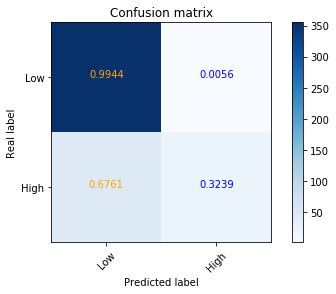

INFO:tensorflow:Restoring parameters from models/model_v2.ckpt
INFO:tensorflow:Froze 38 variables.
Converted 38 variables to const ops.
310 ops in the final graph.


In [7]:
with open('model_config.json') as data_file:    
    config = json.load(data_file)


params=(config["Mode"],float(config["LearningRate"]),int(config["TrainingEpochs"])
        ,int(config["ChunkSize"]),config["ModelVersion"],float(config["DropoutKeepProb"]),int(config["number_nodes_layer1"]))
#Define model list
action = {
#    "1": (model1,(mode,lr,training_epochs,chunk))
    "2": (model2)
            }

handler = action.get(config["ModelVersion"])
handler(*params)




In [8]:

#import tensorflow as tf
#with tf.Session() as sess2:

    #keep_prob_=1.0

    #loader = tf.train.import_meta_graph('/apps/opt/buying_propensity_model/models/model_v2.ckpt.meta')
    #loader.restore(sess2,'/apps/opt/buying_propensity_model/models/model_v2.ckpt')

    #laded_graph = tf.get_default_graph()

    # = loaded_graph.get_tensor_by_name("x:0")
    #keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
    #training = loaded_graph.get_tensor_by_name("training:0")
    #output = loaded_graph.get_tensor_by_name("output:0")


    #data = "ewogICAgImdsb2JhbGlkIjogIjU1NjY2IiwKICAgICJ2aXNpdHMiOiAzLAogICAgIlRpbWVfU3BlbnRfT25fVmlzaXRfUmFuZ2VfSUQiOiA1LAogICAgImNodHwgdGNjaGF0d2luZG93IjogMTEsCiAgICAiZ2hwfCBzbWJnaHAiOiA2LAogICAgImdocHwgc21iZ2hwfCBidXNpbmVzcyByb3V0aW5nIjogMTEsCiAgICAic21ifCAvYWRkIGNoYW5nZSBzZXJ2aWNlcyI6IDAsCiAgICAic21ifCAvc21hbGxidXNpbmVzcy9wcm9kdWN0cy92ZXJpem9uLXNlcnZpY2UtcHJvdGVjdGlvbi1wbGFuLyI6IDAsCiAgICAic21ifCAvc21hbGxidXNpbmVzcy9zb2x1dGlvbnNhZHZpc29yL3NvbHV0aW9uc2Fkdmlzb3JvdmVydmlldy5qc3AiOiAwLAogICAgInNtYnwgW3Vuc2V0XSI6IDAsCiAgICAic21ifCBhcHBzfCBidXNpbmVzcyBwcmVmZXJyZWQiOiAwLAogICAgInNtYnwgYXBwc3wgZGF0YSBwcm90ZWN0aW9uIHByZW1pdW0iOiAwLAogICAgInNtYnwgYXBwc3wgaW50ZXJuZXQgc2VjdXJpdHkgc3VpdGUiOiAwLAogICAgInNtYnwgYXBwc3wgaW50dWl0IHdlYiBsaXN0aW5ncyI6IDAsCiAgICAic21ifCBhcHBzfCBpbnR1aXQgd2Vic2l0ZXMiOiAwLAogICAgInNtYnwgYXBwc3wgbWVyY2hhbnQgc2VydmljZXMiOiAwLAogICAgInNtYnwgYXBwc3wgdGVjaCBzdXBwb3J0IHBybyI6IDAsCiAgICAic21ifCBhcHBzfCB2ZXJpem9uIGNsb3VkIjogMCwKICAgICJzbWJ8IGFwcHN8IHZ6IHNzIGJ1bmRsZSI6IDAsCiAgICAic21ifCBhcHBzfCB3aWZpIjogMCwKICAgICJzbWJ8IGJkdiI6IDAsCiAgICAic21ifCBidW5kbGVzfCBieW9iIjogMCwKICAgICJzbWJ8IGJ1bmRsZXN8IGVxdWlwbWVudCI6IDAsCiAgICAic21ifCBidW5kbGVzfCBvdmVydmlldyI6IDAsCiAgICAic21ifCBidW5kbGVzfCBzd2l0Y2hpbmciOiAwLAogICAgInNtYnwgY2hlY2sgYXZhaWwgLSBub24gZG8iOiAwLAogICAgInNtYnwgY29uZ3JhdHMgc2F2ZWQgb3JkZXIgZW1haWxlZCI6IDAsCiAgICAic21ifCBjb250YWN0IGJ1c2luZXNzIHNwZWNpYWxpc3QiOiAxMSwKICAgICJzbWJ8IGNvbnRhY3QgYnVzaW5lc3Mgc3BlY2lhbGlzdHwgY29uZmlybSI6IDAsCiAgICAic21ifCBjb250YWN0K2JpbGxpbmciOiAwLAogICAgInNtYnwgY3VzdG9taXplIjogMCwKICAgICJzbWJ8IGV4aXN0aW5nIHNlcnZpY2UiOiAwLAogICAgInNtYnwgZmlvcyBpbnRlcm5ldCI6IDAsCiAgICAic21ifCBmaW9zIGludGVybmV0IHNlcnZpY2UiOiAwLAogICAgInNtYnwgZmlvcyBxYXwgcmV2aWV3IHN1Ym1pdCBvdmVybGF5IjogMCwKICAgICJzbWJ8IGZpb3MgdHYgc2VydmljZSBjb21tICBiYXIgcmVzdGF1cmFudCB2aWV3IjogMCwKICAgICJzbWJ8IGZpb3MgdHYgc2VydmljZSBjb21tIHByaXZhdGUiOiAwLAogICAgInNtYnwgZmlvcyB0diBzZXJ2aWNlIGNvbW0gcHVibGljIjogMCwKICAgICJzbWJ8IGdvb2QgbmV3cyBvcmRlciBzYXZlZCI6IDAsCiAgICAic21ifCBoc2kiOiAwLAogICAgInNtYnwgaHNpIGludGVybmV0IHNlcnZpY2UiOiAwLAogICAgInNtYnwgaHNpIGxpbmUyIGludGVybmV0IHNlcnZpY2UiOiAwLAogICAgInNtYnwgaW5zdGFsbCt0b3MiOiAwLAogICAgInNtYnwgbGJvIjogMCwKICAgICJzbWJ8IGxibyAtIHN0YW5kYWxvbmUgZGF0YSBvciB0diBhY2NvdW50IjogMCwKICAgICJzbWJ8IGxiby0gciB0eXBlIjogMCwKICAgICJzbWJ8IGxxIGFkZHJlc3MgdmVyaWZpY2F0aW9uIjogMSwKICAgICJzbWJ8IGxxIGNoZWNrIGF2YWlsIjogNCwKICAgICJzbWJ8IGxxIGhlbHAiOiAwLAogICAgInNtYnwgbHEgbXVsdGlwbGUgYWRkcmVzc3MiOiAyLAogICAgInNtYnwgbHEgcmVzdWx0cyI6IDIsCiAgICAic21ifCBtbHB8IGNsfCBidW5kbGVzIjogMCwKICAgICJzbWJ8IG1scHwgY2x8IGludGVybmV0IjogMCwKICAgICJzbWJ8IG1scHwgY2x8IHZvaWNlIjogMCwKICAgICJzbWJ8IG5vbiBkbyBsYW5kaW5nIjogOCwKICAgICJzbWJ8IG91dCBvZiBmcmFuY2hpc2UiOiAwLAogICAgInNtYnwgcGVuZGluZyBvcmRlciI6IDAsCiAgICAic21ifCBwaG9uZSI6IDAsCiAgICAic21ifCBwaG9uZSBjb25maWciOiAwLAogICAgInNtYnwgcGhvbmUgbnVtYmVyIjogMCwKICAgICJzbWJ8IHJ2fCBzbWIgZXhwYW5kZWQgbHAiOiAwLAogICAgInNtYnwgc2hvcHwgc3BlY2lhbCBvZmZlcnMiOiAzLAogICAgInNtYnwgc21iZ2hwIjogMSwKICAgICJzbWJ8IHNvbHV0aW9uIGFkdmlzb3IiOiAwLAogICAgInNtYnwgc3VwZXIgc2VsZWN0IHNlcnZpY2VzIjogMCwKICAgICJzbWJ8IHN1cGVyIHNlbGVjdCBzZXJ2aWNlcyBkaXJlY3Qgb3JkZXJpbmcgYnVuZGxlcyI6IDAsCiAgICAic21ifCBUQ2NoYXR3aW5kb3ciOiAwLAogICAgInNtYnwgdG9zfCBzZWUgdGhlIHRlcm1zIjogMCwKICAgICJzbWJ8IHR2IHNlZ21lbnQiOiAwLAogICAgInNtYnwgdHZ8IGZpb3MgcGFja2FnZXMiOiAwLAogICAgInNtYnwgdmVyaWZ5YWRkciI6IDAsCiAgICAic21ifCB2ZXJpZnlzZXJ2aWNlczMiOiAwLAogICAgInNyY2h8IHNpdGUgc2VhcmNoIHJlc3VsdHMiOiAwLAogICAgInZ6Y3wgbXkgc2VydmljZXMiOiAwCiAgfQ=="
    #m=base64.b64decode(data).decode('utf-8')


    #xk = json.loads(m)
    #print (len(xk.keys()))

    #x_test=pre_process(xk)

    #print (x_test.shape)

    #x_test2= x_test.iloc[:,1:].as_matrix()
    #keep_prob_=1
    
    #train_writer = tf.summary.FileWriter('./traing',sess2.graph)
    #test_writer = tf.summary.FileWriter('./testg')
    #test_writer2 = tf.summary.FileWriter('./test2g')
    
    


    
    #a_p = sess2.run(output, feed_dict={x:x_test2, keep_prob: keep_prob_, training:False})

    #print ("1ero : " , a_p)
    #test_writer.add_summary(a_p,"1")

    #x_test3=pd.concat([test_df.iloc[:,1:3] ,test_df.iloc[:,147:218]], axis=1).as_matrix()

    #x_test3=test_df.iloc[:,:].as_matrix()



    #a_p = sess2.run(output, feed_dict={x:x_test3, keep_prob: keep_prob_, training:False})
    #print ("2do : " , a_p)
    
    
    #x_test3=test_df2.iloc[:,:].as_matrix()
    #a_p = sess2.run(output, feed_dict={x:x_test3, keep_prob: keep_prob_, training:False})
    #print ("3 ero : " , a_p)

    #x_test3=test_df3.iloc[:,:].as_matrix()
    #a_p = sess2.run(output, feed_dict={x:x_test3, keep_prob: keep_prob_, training:False})
    #print ("4 to : " , a_p)
    
    
    #x_test3=test_df3.iloc[0:1,:].as_matrix()
    #a_p = sess2.run(output, feed_dict={x:x_test3, keep_prob: keep_prob_, training:False})
    #print ("5 to : " , a_p)


   
    #sess2.close()



In [ ]:
[{MGR_ID: 20 , 
 catalagos:[ {
       Atributo:"ENTRADA_ADUANA",
       Diccionario : {   
                 
            '14011975002583': 173,
            '08019002262680': 104,
            '08011978139599': 84,
            '08019002278950': 114,
            '08019995158231': 145,
            '08019995158367': 146
            }
        },
     {
      Atributo:"ENTRADA_AGENTE",
       Diccionario : {   
                 
            '14011975002583': 173,
            '08019002262680': 104,
            '08011978139599': 84,
            '08019002278950': 114,
            '08019995158231': 145,
            '08019995158367': 146
            }   
     }
 ]
     
  
 array
  
metadata= read_csv("metadata.csv")
mGRID = 222222
metadata= {"Entrda Aduna", "Entrda Agente", "xxxx"}
  
json= {"MGRID":mGRID,"Catalogos":[]}
  
 FOR iterar metadata
    json.catalogos.push({Atributo:})
    Atributo= metada.atributo 
    
    diccionario=extraercategoria(data.iloc[Atributo])
    
    addjson
  
  

